In [48]:
%load_ext autoreload
%autoreload 2
import sys
# sys.path.append("/u/jai/stancetaking/utils")

from utils.data_utils import *
from utils.topic_utils import *

import itertools
from itertools import product
from sklearn.manifold import MDS
from scipy.spatial.distance import pdist, squareform
import seaborn as sb
from scipy.stats import boxcox, pearsonr, multivariate_normal

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Global variables
data_suffix = "may_17_intensifiers_vadpf_3_bins"
FEATURE_COLUMNS = ['Valence', 'Arousal', 'Dominance', 'Politeness', 'Formality']
LINGUISTIC_PROPERTIES = FEATURE_COLUMNS + [col + "_Absolute" for col in FEATURE_COLUMNS]

# dim_to_title is used for visualizing need probabilities
dim_to_title = {
        "v": "Valence",
        "a": "Arousal",
        "d": "Dominance",
        "p": "Politeness",
        "f": "Formality",
        "va": "Valence/Arousal",
        "vd": "Valence/Dominance",
        "dpf": "Dominance/Politeness/Formality",
    }

# Plotting parameters
font = {'font.size'   : 12,
        'xtick.labelsize': 15, #13 before
        'ytick.labelsize': 15}

plt.rcParams.update(font)

Num markers: 38
(1798, 38)
0.4
[0.377 0.094 0.072 0.054 0.042 0.035 0.03  0.026 0.022 0.02  0.016 0.016
 0.015 0.014 0.013]
[0.         0.37727139 0.47157158 0.54346476 0.59786693 0.64024884
 0.67543274 0.70561892 0.73145169 0.7534679  0.7735555  0.78980085
 0.80568728 0.82057521 0.83459799]


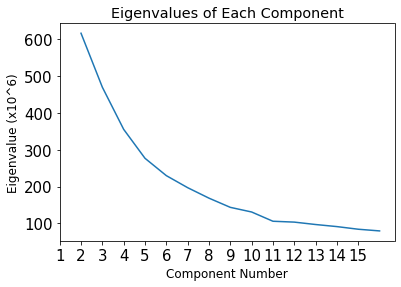

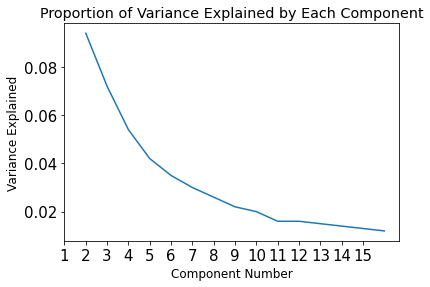

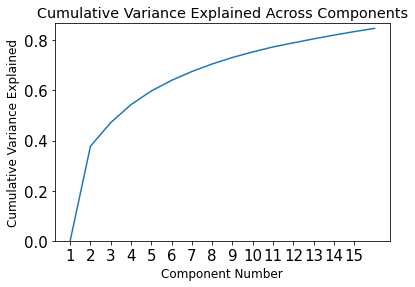

<Figure size 432x288 with 0 Axes>

In [3]:
# Load Pavalanathan data and associated global variables
pav_matrix = Serialization.load_obj(f"pavalanathan_cooc_data_{data_suffix}") # change {full_data} to {intensifiers} to get subset
# pav_matrix = pav_matrix[pav_matrix.index.str.lower().isin(full_dist_df.index)]
####
# pav_matrix = pav_matrix[overlap]
####
com_counts = pav_matrix.sum(axis=1).sort_values()
communities = pav_matrix.index.tolist()
intensifiers = pav_matrix.columns.tolist()

print(f"Num markers: {len(intensifiers)}")

# Perform SVD on Pavalanathan data
pav_svd_output = generate_latent_representations(
    matrix=pav_matrix, 
    label="pav_ppmi_95_var", 
    title="Pavalanathan",
    data_suffix=data_suffix,
    include_ppmi=True
)

# Decide how many dimensions to keep
x = scree_plots(pav_svd_output['singular_values'][:], "Pavalanathan", data_suffix, 
                axis_offset=1, num_dim_to_show=15)
pav_latent_representation = pav_svd_output['new_sem_loadings'][:,:11]

In [4]:
# We no longer try the functional embeddings
FEATURE_COLUMNS = ['Valence', 'Arousal', 'Dominance', 'Politeness', 'Formality']
LINGUISTIC_PROPERTIES = FEATURE_COLUMNS + [col + "_Absolute" for col in FEATURE_COLUMNS]

# Load data frames
print("Load dataframe..")
sentence_df = Serialization.load_obj(f"stance_pipeline_full_data_with_sentences_{data_suffix}")
print(sentence_df.shape)

###
# sentence_df = sentence_df[sentence_df['rel_marker'].isin(overlap)]
# print(sentence_df.shape)
###

# Compute extremeness
print("Compute extremeness...")
sentence_df[[col + "_Absolute" for col in FEATURE_COLUMNS]] = np.abs(sentence_df[FEATURE_COLUMNS] - sentence_df[FEATURE_COLUMNS].mean())

# Creating community-level contextual representations
print("Creating community representations...")
community_representation = sentence_df[['subreddit'] + LINGUISTIC_PROPERTIES].groupby(['subreddit']).mean()
community_representation = community_representation.loc[pav_matrix.index]
centered_community_representation = (community_representation - community_representation.mean(axis=0))
rescaled_community_representation = centered_community_representation / community_representation.std(axis=0)


# Creating word-level contextual representations
print("Creating word-level representations...")
marker_representation = sentence_df[['subreddit', 'rel_marker'] + LINGUISTIC_PROPERTIES].groupby(['subreddit', 'rel_marker']).mean()
marker_representation = marker_representation.reset_index()
marker_representation['column_name'] = marker_representation['subreddit'] + "_" + marker_representation['rel_marker']
marker_representation = marker_representation.set_index('column_name')

# Center the embeddings
centered_marker_representation = (marker_representation[LINGUISTIC_PROPERTIES] - marker_representation[LINGUISTIC_PROPERTIES].mean(axis=0))
rescaled_marker_representation = centered_marker_representation / marker_representation.std(axis=0)

Load dataframe..
(17980000, 11)
Compute extremeness...
Creating community representations...
Creating word-level representations...


In [57]:
np.argsort(textual_svd.explained_variance_ratio_)#[::-1][:7]

array([99, 98, 97, 96, 95, 94, 93, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83,
       82, 81, 80, 79, 78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66,
       65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49,
       48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32,
       31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15,
       14, 13, 12, 11, 10,  9,  8,  0,  7,  6,  5,  4,  3,  2,  1])

In [5]:
textual_svd = Serialization.load_obj("textual_tf_idf_svd_sentence_df")
textual_representations = np.load('/ais/hal9000/datasets/reddit/brian_unigrams/tf_idf_storage/svd-tf-idf_unigrams_sentence_df.npy')[:, np.argsort(textual_svd.explained_variance_ratio_)[::-1][:7]]
textual_representation_rows = pd.read_csv('/ais/hal9000/datasets/reddit/brian_unigrams/tf_idf_storage/unigram_rows_sentence_df', header=None)
textual_representation_df = pd.DataFrame(textual_representations, index=textual_representation_rows[0])

# communities_with_data = (Serialization.load_obj("luo_data_2019_10k_sample")['subreddit'].unique(), textual_representation_df.index)
textual_representation_df = textual_representation_df.loc[rescaled_community_representation.index.str.lower()]
textual_representation_sims = pd.DataFrame(cosine_similarity(textual_representation_df), index=textual_representation_df.index, columns=textual_representation_df.index)

In [6]:
# plot_variance_explained(textual_svd.explained_variance_ratio_[np.argsort(textual_svd.explained_variance_ratio_)[::-1]], 20, f"/u/jai/stancetaking/images/latent_dimensions/structure_exploration/{data_suffix}/", 'textual_svd', 0)

In [7]:
assert all(rescaled_community_representation.index == pav_matrix.index)
assert all(rescaled_community_representation.index == communities)
assert all(textual_representation_sims.index == rescaled_community_representation.index)

In [8]:
pav_similarity_values = cosine_similarity(pav_latent_representation[:, :7])
pav_df_7_dim = pd.DataFrame(pav_similarity_values, index=communities, columns=communities)
# Serialization.save_obj(pav_df_7_dim, f"rq2_{data_suffix}_pav_df_7")

pav_similarity_values = cosine_similarity(pav_latent_representation)
pav_df_11_dim = pd.DataFrame(pav_similarity_values, index=communities, columns=communities)
# Serialization.save_obj(pav_df_11_dim, f"rq2_{data_suffix}_pav_df_11_dim")

In [9]:
community_similarity_values = cosine_similarity(centered_community_representation)
contextual_df = pd.DataFrame(community_similarity_values, index=communities, columns=communities)

community_similarity_values_std = cosine_similarity(rescaled_community_representation)
contextual_df_std = pd.DataFrame(community_similarity_values_std, index=communities, columns=communities)

# Serialization.save_obj(contextual_df_std, f"rq2_{data_suffix}_contextual_df_standardized")

In [10]:
def get_unique_pairwise_sims(pairwise_df):
    unique_values = pairwise_df.to_numpy()[np.triu_indices(pairwise_df.shape[0], k=1)]
    return unique_values

In [11]:
model_info = {
    "contextual": {
        "df": contextual_df,
        "metric_name": "Contextual Similarity",
        "unique_values": get_unique_pairwise_sims(contextual_df)
    },
    "contextual_std": {
        "df": contextual_df_std,
        "metric_name": "Contextual Similarity",
        "unique_values": get_unique_pairwise_sims(contextual_df_std)
    },
    "pav_7": {
        "df": pav_df_7_dim,
        "metric_name": "Marker Preference Similarity",
        "unique_values": get_unique_pairwise_sims(pav_df_7_dim)
    },
    "pav_11": {
        "df": pav_df_11_dim,
        "metric_name": "Marker Preference Similarity",
        "unique_values": get_unique_pairwise_sims(pav_df_11_dim)
    },
    "textual": {
        "df": textual_representation_sims,
        "metric_name": "Textual Similarity",
        "unique_values": get_unique_pairwise_sims(textual_representation_sims)
    }
}

In [12]:
print(pearsonr(model_info['contextual_std']['unique_values'], model_info['textual']['unique_values']))
print(pearsonr(model_info['pav_11']['unique_values'], model_info['contextual_std']['unique_values']))
print(pearsonr(model_info['pav_11']['unique_values'], model_info['textual']['unique_values']))

(0.5180487050656061, 0.0)
(0.3729819634013525, 0.0)
(0.3879359153177586, 0.0)


# Topic Mapping

In [13]:
# sub_to_topic, sub_to_special_topic, topic_to_special_topic = load_topics()
# for sub in sub_to_special_topic:
#     if sub.startswith("ask"):
#         sub_to_special_topic[sub] = ["discussion_question/answer"] + sub_to_special_topic[sub]

In [14]:
with open("../data_files/subreddit_topics/main_subreddit_topics.txt", "r") as file:
    subreddit_topics = file.readlines()

print(len(subreddit_topics))

sub_to_topic = defaultdict(list)
sub_to_special_topic = defaultdict(list)
topic_to_special_topic = defaultdict(list)

curr_topic = None
curr_special_topic = None

for topic in tqdm(subreddit_topics):
    topic = topic.strip().lower()
    if len(topic) < 3:
        continue
    if re.match(r"^#\s?\*", topic):
        topic = re.findall(r"[^\*#]{2,}", topic)[0]
        curr_topic = topic
    elif re.match(r"^##\s?\*", topic):
        topic = re.findall(r"[^\*#]{2,}", topic)[0]
        curr_special_topic = topic
        topic_to_special_topic[curr_topic].append(curr_special_topic)
    elif re.match(r"^#{3,}\s?\*", topic):
        continue
    elif topic.startswith("**/r"):
        topic = topic.split(" ")[0]
        topic = topic[5:-2]
        sub_to_topic[topic].append(curr_topic)
        sub_to_special_topic[topic].append(curr_topic + "_" + curr_special_topic)
    elif topic.startswith("/r"):
        topic = topic.split(" ")[0]
        topic = topic[3:]
        sub_to_topic[topic].append(curr_topic)
        sub_to_special_topic[topic].append(curr_topic + "_" + curr_special_topic)
    else:
        print(topic)
    
topic_file_to_topic = {
    "advice": "discussion_advice",
    "art": "hobbies/occupations_arts/writing",
    "cars": "hobbies/occupations_automotive",
    "discussion": "discussion_general",
    "diy": "hobbies/occupations_general",
    "education": "educational_general",
    "food": "lifestyle_food",
    "general_sports": "entertainment_sports",
    "location_reddits": "other_geography",
    "memes": "humor_memes/rage comics",
    "music": "entertainment_music",
    "nsfw": "nsfw",
    "politics": "other_news/politics",
    "scifi": "entertainment_genres",
    "tech": "technology_general",
    "universities": "other_universities",
    "video_games": "entertainment_video_games"
}

sub_to_topic, sub_to_special_topic, topic_to_special_topic = load_topics()

for sub in sub_to_special_topic:
    if sub.startswith("ask"):
        sub_to_special_topic[sub] = ["discussion_question/answer"] + sub_to_special_topic[sub]

2936


100%|██████████| 2936/2936 [00:00<00:00, 176988.08it/s]


sourced from: https://www.reddit.com/r/listofsubreddits/wiki/listofsubreddits/?show_source
---
for more advice/assistance subreddits, [see here!](http://www.reddit.com/r/listofsubreddits/wiki/advice)
---
## general
for more, see [the wiki compiled](http://www.reddit.com/r/historynetwork/wiki/listofhistorysubreddits) by /r/historynetwork!
note: many of those subreddits are inactive.
---
## [**video games**](https://www.reddit.com/r/listofsubreddits/wiki/games50k)
*the above is the complete list of every video game subreddit with currently 50k or more subscribers!*
[for other sci-fi subreddits, see here!](https://www.reddit.com/r/spacegeek/wiki/relatedsubreddits)
###  *4chan*
much more \[here\]\(http://www.reddit.com/r/listentothis/about/sidebar\) from the sidebar of /r/listentothis!
see especially \[the fire hose\]\(http://www.reddit.com/user/evilnight/m/thefirehose\) curated by /u/evilnight. all subreddits are active!
[sports subreddits!](http://www.reddit.com/r/listofsubreddits/wiki/s

100%|██████████| 2936/2936 [00:00<00:00, 198102.97it/s]

sourced from: https://www.reddit.com/r/listofsubreddits/wiki/listofsubreddits/?show_source
---
for more advice/assistance subreddits, [see here!](http://www.reddit.com/r/listofsubreddits/wiki/advice)
---
## general
for more, see [the wiki compiled](http://www.reddit.com/r/historynetwork/wiki/listofhistorysubreddits) by /r/historynetwork!
note: many of those subreddits are inactive.
---
## [**video games**](https://www.reddit.com/r/listofsubreddits/wiki/games50k)
*the above is the complete list of every video game subreddit with currently 50k or more subscribers!*
[for other sci-fi subreddits, see here!](https://www.reddit.com/r/spacegeek/wiki/relatedsubreddits)
###  *4chan*
much more \[here\]\(http://www.reddit.com/r/listentothis/about/sidebar\) from the sidebar of /r/listentothis!
see especially \[the fire hose\]\(http://www.reddit.com/user/evilnight/m/thefirehose\) curated by /u/evilnight. all subreddits are active!
[sports subreddits!](http://www.reddit.com/r/listofsubreddits/wiki/s

In [15]:
def generate_similarity_df(curr_df):
    education = list(map(lambda x: "_".join(x), product(["educational"], topic_to_special_topic['educational'])))
    discussion = list(map(lambda x: "_".join(x), product(["discussion"], topic_to_special_topic['discussion'])))
    entertainment = list(map(lambda x: "_".join(x), product(["entertainment"], topic_to_special_topic['entertainment'])))
    lifestyle = list(map(lambda x: "_".join(x), product(["lifestyle"], topic_to_special_topic['lifestyle'])))
    technology = list(map(lambda x: "_".join(x), product(["technology"], topic_to_special_topic['technology'])))
    hobbies = list(map(lambda x: "_".join(x), product(["hobbies/occupations"], topic_to_special_topic['hobbies/occupations'])))
    humor = list(map(lambda x: "_".join(x), product(["humor"], topic_to_special_topic['humor'])))
    animals = list(map(lambda x: "_".join(x), product(["animals"], topic_to_special_topic['animals'])))
    other = list(map(lambda x: "_".join(x), product(["other"], topic_to_special_topic['other'])))


    return (pd.DataFrame(curr_df).replace({"other_geography": "locations", "other_news/politics": "politics", "entertainment_sports": "sports", "entertainment_video_games": "video_games", 
                                           "educational_general": "education",  "educational_support": "education", "technology_self-improvement": "technology", 
                                           "animals_memes/rage comics": "animals", "animals": "animals", "general content_images": "general", "general content_gifs": "general", 
                                           "general content_videos": "general", "other_universities": "other"
                                           })
            .replace({sub: "education" for sub in education})
            .replace({sub: "discussion" for sub in discussion})
            .replace({sub: "entertainment" for sub in entertainment})
            .replace({sub: "lifestyle" for sub in lifestyle})
            .replace({sub: "technology" for sub in technology})
            .replace({sub: "hobbies" for sub in hobbies})
            .replace({sub: "humor" for sub in humor})
            .replace({sub: "animals" for sub in animals})
            .replace({sub: "other" for sub in other})
        )


In [16]:
all_topics = pd.DataFrame(rescaled_community_representation.index.map(lambda com: sub_to_special_topic[com][0] if len(sub_to_special_topic[com]) > 0 else 'no_topic_assigned'), index=rescaled_community_representation.index)
all_topics = generate_similarity_df(all_topics)
all_topics.columns = ['topic']
topic_to_subreddit = all_topics.reset_index().groupby("topic").agg(list)
topic_to_subreddit['num_subs'] = topic_to_subreddit['subreddit'].apply(len)
topic_to_subreddit['num_subs'].sort_values(ascending=False)

topic
no_topic_assigned    589
entertainment        176
video_games          159
lifestyle            151
sports               142
other                107
locations             96
hobbies               94
discussion            84
education             70
technology            50
politics              20
humor                 20
general               18
nsfw                  15
animals                7
Name: num_subs, dtype: int64

In [17]:
topics_of_interest = sorted(['education', 'video_games',  'entertainment', 'technology', 'hobbies', 'sports', 'politics', 'locations', 'discussion', 'lifestyle', 'humor', 'nsfw', 'animals'])
topic_to_topic_text_sim = {topic: {} for topic in topics_of_interest}
topic_to_topic_stance_sim = {topic: {} for topic in topics_of_interest}
topic_to_topic_marker_sim = {topic: {} for topic in topics_of_interest}

for topic_1 in tqdm(topics_of_interest):
    for topic_2 in topics_of_interest:
        topic_1_coms = topic_to_subreddit.loc[topic_1]['subreddit']
        topic_2_coms = topic_to_subreddit.loc[topic_2]['subreddit']
        curr_textual_sims = textual_representation_sims.loc[topic_1_coms][topic_2_coms]
        curr_contextual_sims = contextual_df_std.loc[topic_1_coms][topic_2_coms]
        curr_marker_sims = pav_df_11_dim.loc[topic_1_coms][topic_2_coms]
        
        topic_to_topic_text_sim[topic_1][topic_2] = np.mean(np.mean((curr_textual_sims)))
        topic_to_topic_stance_sim[topic_1][topic_2] = np.mean(np.mean((curr_contextual_sims)))
        topic_to_topic_marker_sim[topic_1][topic_2] = np.mean(np.mean((curr_marker_sims)))



  0%|          | 0/13 [00:00<?, ?it/s]

100%|██████████| 13/13 [00:00<00:00, 14.94it/s]


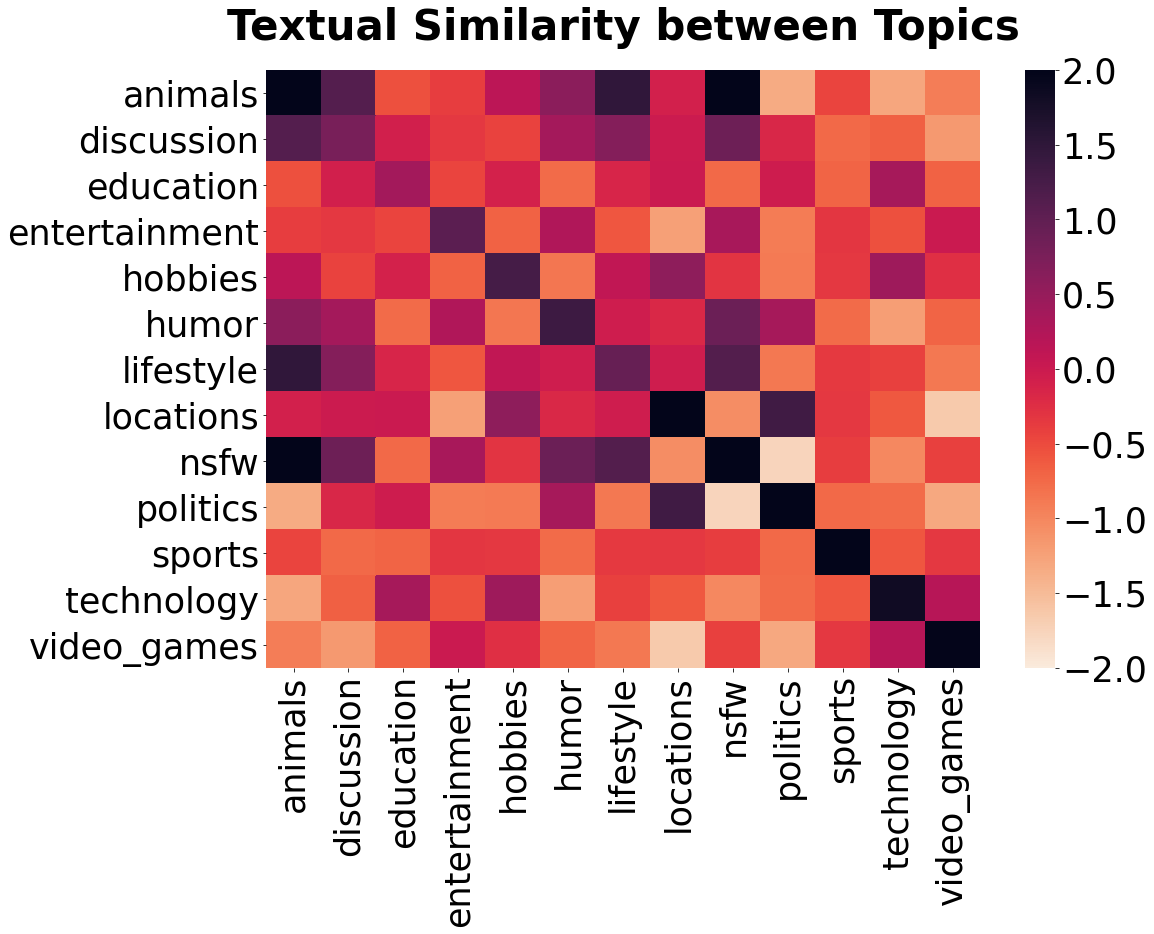

In [18]:
topic_heatmap = topic_similarity_heatmaps(topic_to_topic_text_sim, "Textual Similarity between Topics", to_normalize=True, vmax=2)

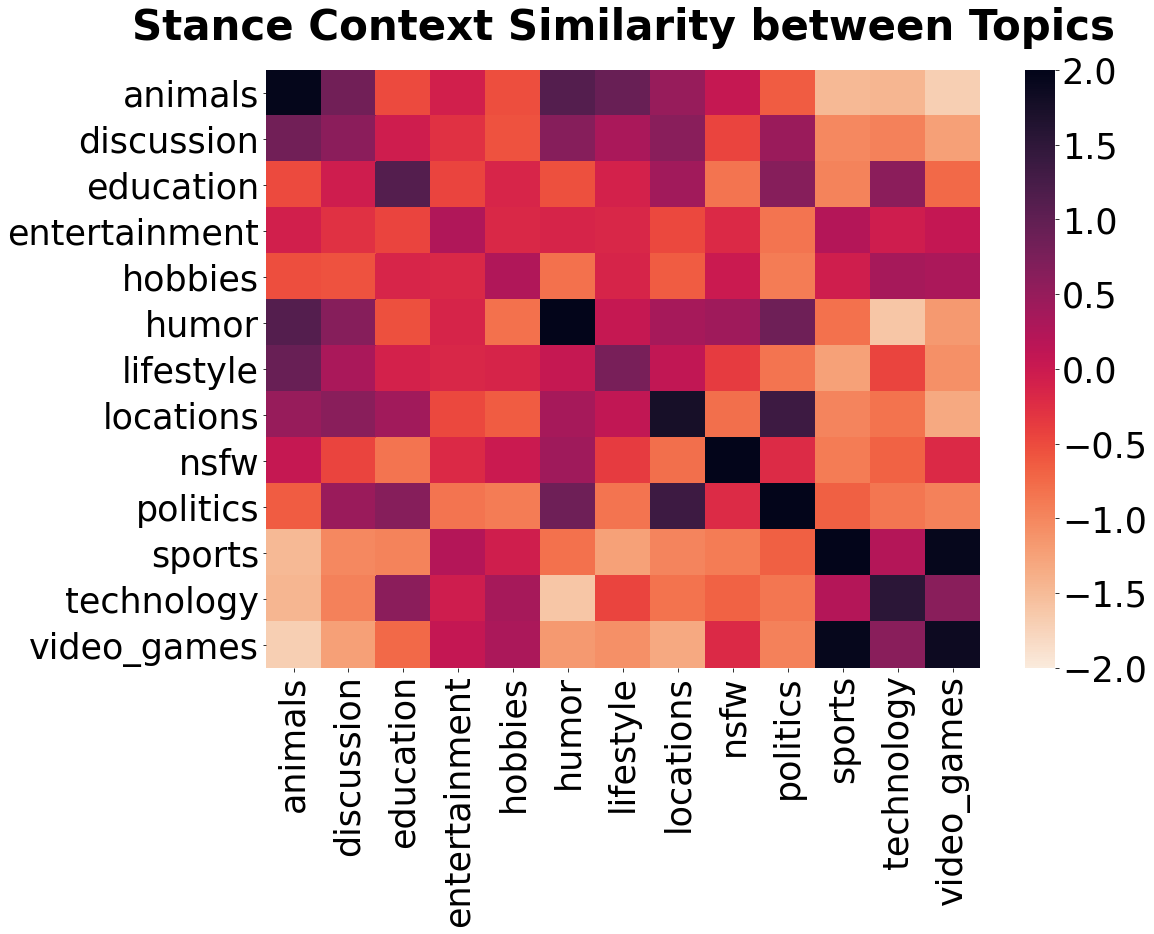

In [19]:
stance_heatmap = topic_similarity_heatmaps(topic_to_topic_stance_sim, "Stance Context Similarity between Topics", to_normalize=True, vmax=2)

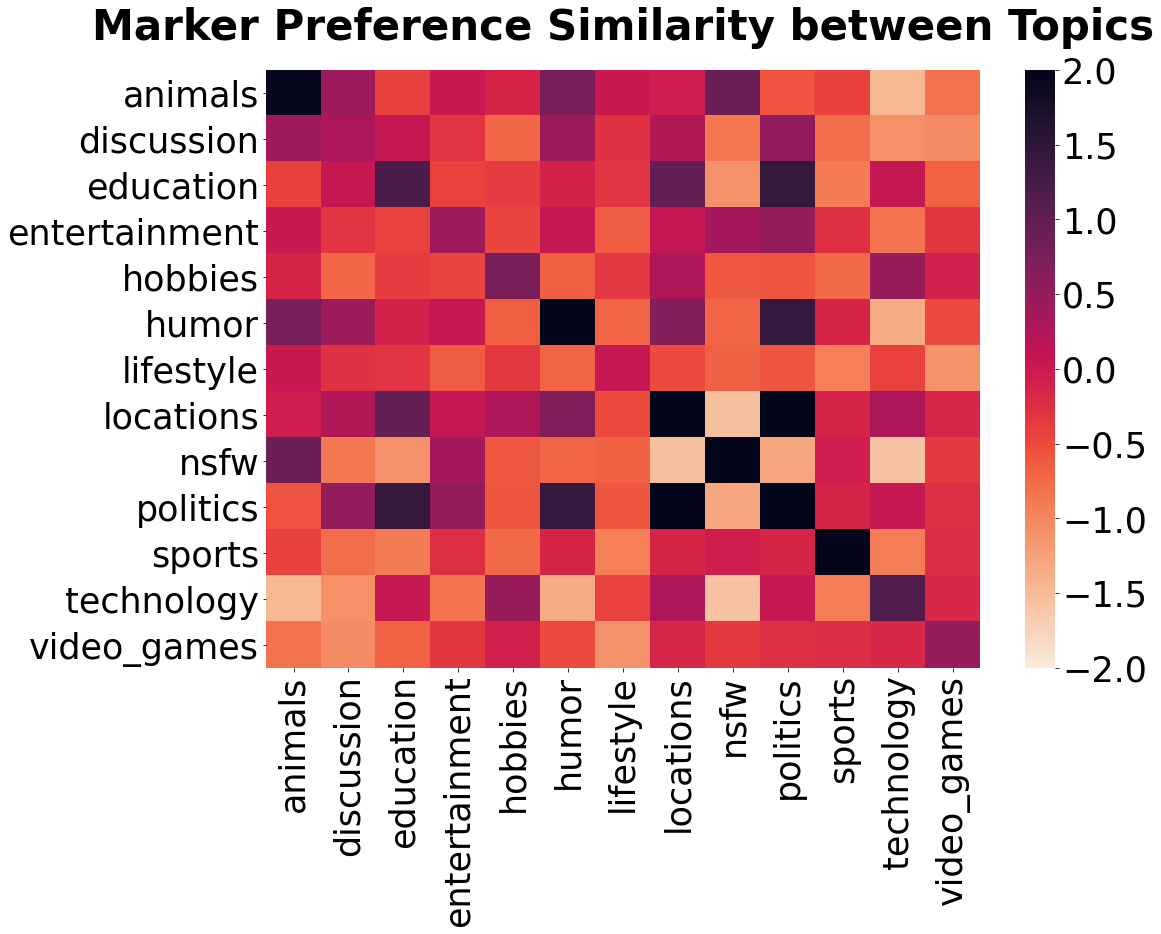

In [20]:
marker_heatmap = topic_similarity_heatmaps(topic_to_topic_marker_sim, "Marker Preference Similarity between Topics", to_normalize=True, vmax=2)

In [21]:
STANCE_HATCH = "x"
TEXT_HATCH = ""
MARKER_HATCH = "|"

rep_to_hatch = {
    "stance": STANCE_HATCH,
    "text": TEXT_HATCH,
    'marker': MARKER_HATCH
}

rep_to_colour = {
    "stance": 13,
    "text": 231,
    'marker': 297 
}

def topic_diffs_heatmap(data, title, vmax, rep_1, rep_2):
    font = {'font.size'   : 35,
        'xtick.labelsize': 35, #13 before
        'ytick.labelsize': 35,
        "axes.titlepad": 30}

    plt.rcParams.update(font)
    fig, ax = plt.subplots(figsize = (16,11))
    x= np.arange(len(data.columns)+1)
    y= np.arange(len(data.index)+1)

    rep_1_mask = np.ma.masked_greater(data.values, 0)
    rep_2_mask = np.ma.masked_less(data.values, 0)

    annotated = data.mask(data > 0, 100)
    annotated = annotated.mask(annotated < 0, -100)
    annotated = annotated.replace(100, rep_to_hatch[rep_1]).replace(-100, rep_to_hatch[rep_2])

    # data = np.abs(data)

    if vmax:
        sb.heatmap(data, cmap=sb.diverging_palette(rep_to_colour[rep_2], rep_to_colour[rep_1], s=100, l=40, as_cmap=True, n=10), vmin=-vmax, vmax=vmax, ax=ax) #cmap="PiYG_r",annot=annotated, fmt="s" annot=annotated, fmt="s", annot_kws={"fontsize": 10}
        # ax.pcolor(x, y, rep_1_mask, hatch=rep_to_hatch[rep_1], alpha=0.)
        # ax.pcolor(x, y, rep_2_mask, hatch=rep_to_hatch[rep_2], alpha=0.)

    else:
        sb.heatmap(data, cmap="flare")
    plt.title(f"{title}", fontweight='bold')



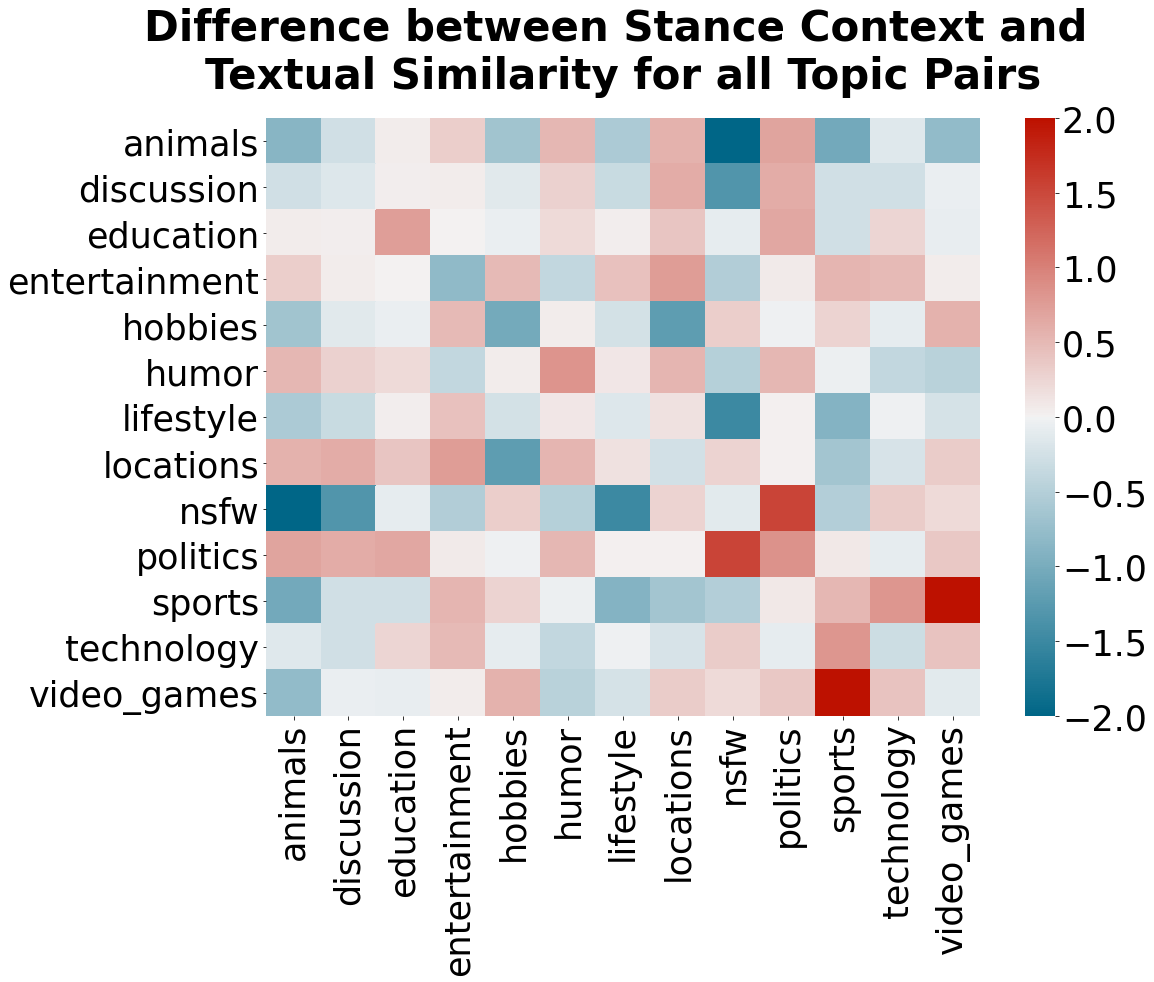

In [22]:
diffs_heatmap = topic_diffs_heatmap(stance_heatmap - topic_heatmap, "Difference between Stance Context and \nTextual Similarity for all Topic Pairs", vmax=2, rep_1='stance', rep_2='text')

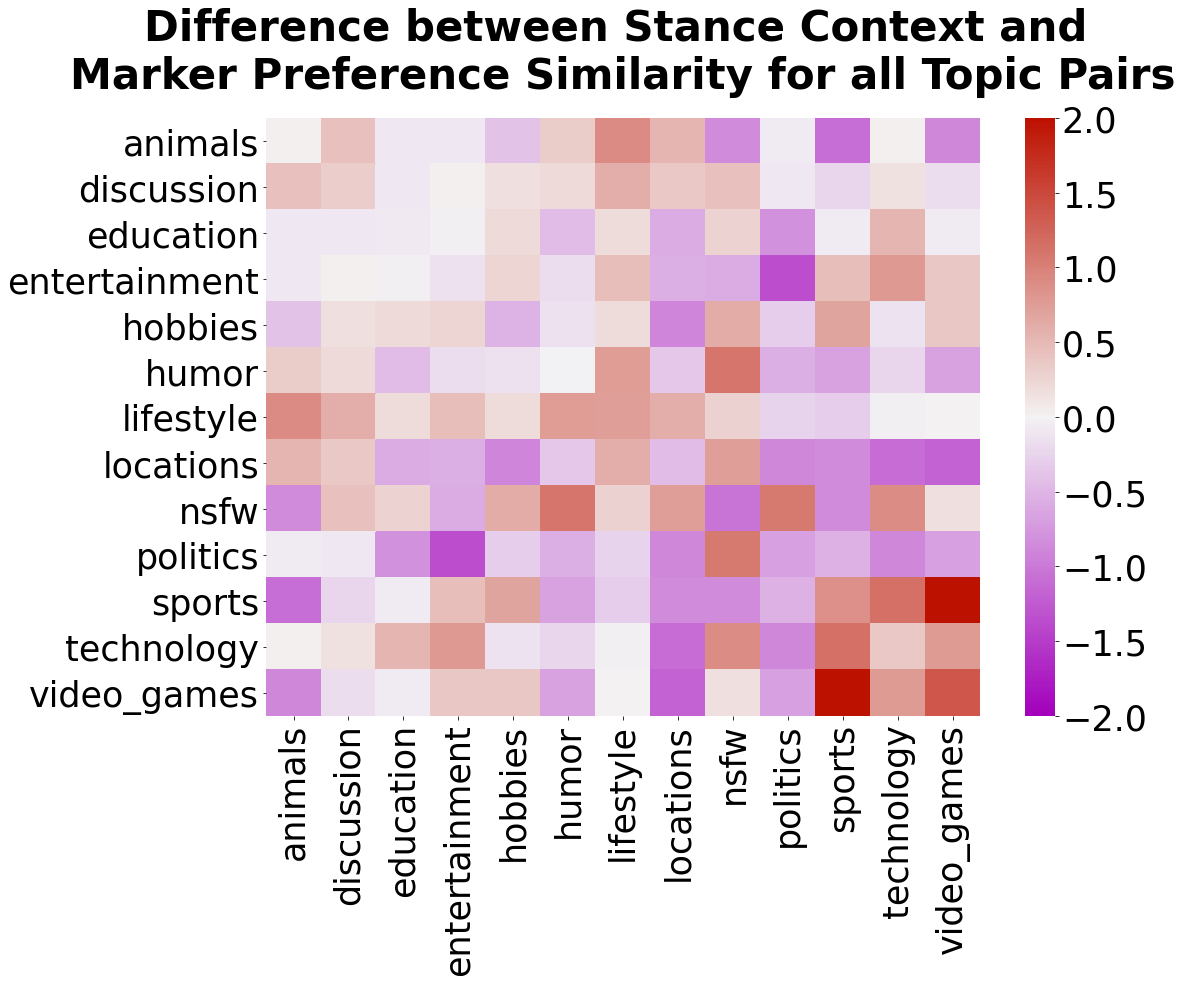

In [23]:
diffs_heatmap = topic_diffs_heatmap(stance_heatmap - marker_heatmap, "Difference between Stance Context and \nMarker Preference Similarity for all Topic Pairs", vmax=2, rep_1='stance', rep_2='marker')

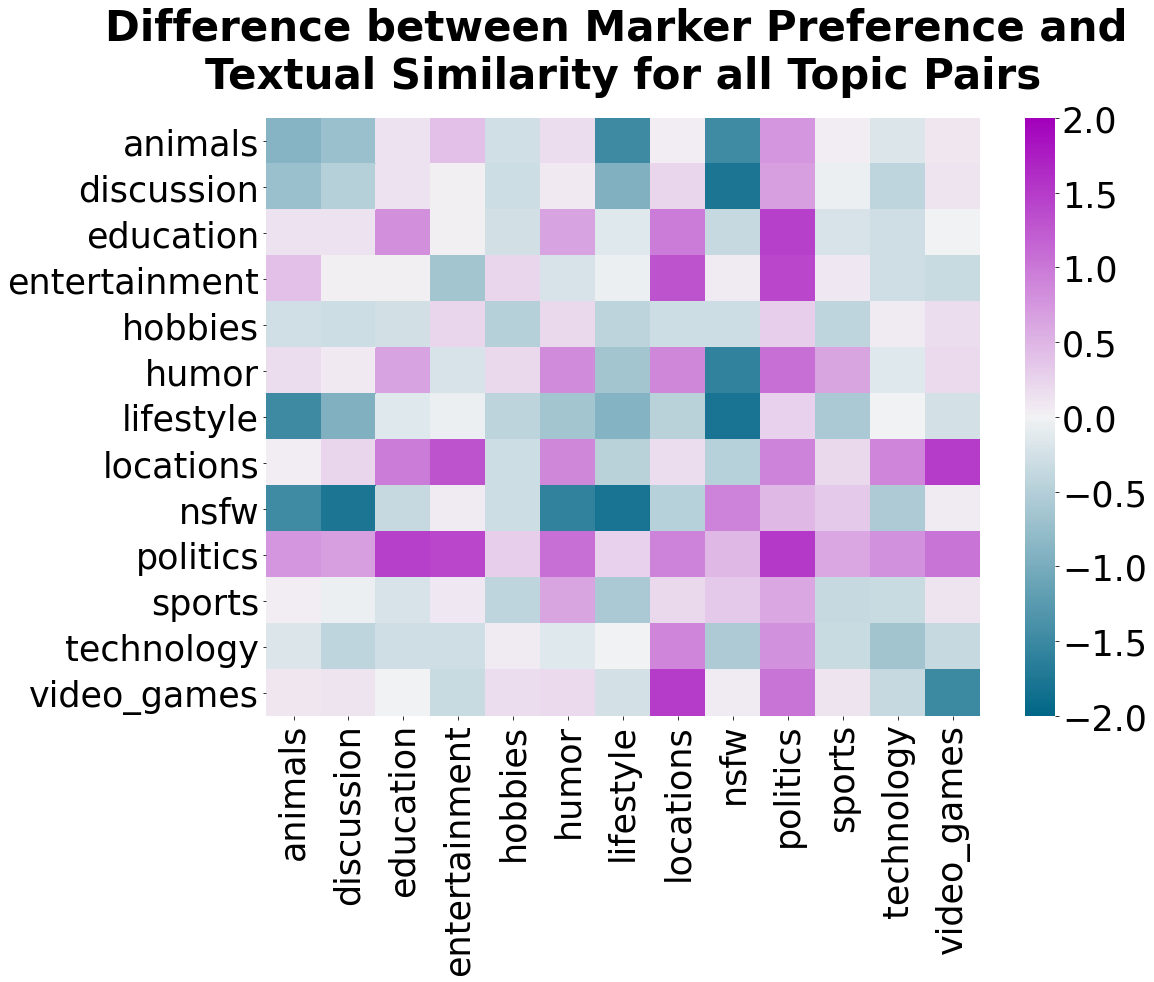

In [24]:
diffs_heatmap = topic_diffs_heatmap(marker_heatmap - topic_heatmap, "Difference between Marker Preference and \nTextual Similarity for all Topic Pairs", vmax=2, rep_1='marker', rep_2='text')

In [25]:
marker_heatmap

,animals,discussion,education,entertainment,hobbies,humor,lifestyle,locations,nsfw,politics,sports,technology,video_games
animals,1.945636,0.413836,-0.412841,0.024444,-0.126647,0.770674,0.017312,-0.045570,0.901486,-0.577922,-0.398431,-1.460232,-0.817762
discussion,0.413836,0.284523,0.055597,-0.301806,-0.727353,0.438550,-0.276130,0.242166,-0.869046,0.540190,-0.769284,-1.087149,-1.039818
education,-0.412841,0.055597,1.190063,-0.433161,-0.362865,-0.097815,-0.298845,0.982188,-1.103532,1.440369,-0.906209,0.058628,-0.681015
entertainment,0.024444,-0.301806,-0.433161,0.411367,-0.444278,0.051620,-0.628096,0.077975,0.389187,0.526459,-0.243192,-0.821088,-0.318264
hobbies,-0.126647,-0.727353,-0.362865,-0.444278,0.776394,-0.643651,-0.334430,0.270570,-0.607545,-0.593339,-0.748602,0.482165,-0.083873
humor,0.770674,0.438550,-0.097815,0.051620,-0.643651,2.193681,-0.688383,0.699281,-0.692661,1.429550,-0.134319,-1.355217,-0.491415
lifestyle,0.017312,-0.276130,-0.298845,-0.628096,-0.334430,-0.688383,0.043282,-0.494724,-0.658116,-0.588902,-0.926281,-0.423818,-1.098276
locations,-0.045570,0.242166,0.982188,0.077975,0.270570,0.699281,-0.494724,2.193179,-1.535395,2.232122,-0.131384,0.292163,-0.142584
nsfw,0.901486,-0.869046,-1.103532,0.389187,-0.607545,-0.692661,-0.658116,-1.535395,3.512867,-1.283787,-0.055013,-1.570066,-0.354170
politics,-0.577922,0.540190,1.440369,0.526459,-0.593339,1.429550,-0.588902,2.232122,-1.283787,4.013018,-0.126264,0.038926,-0.259968


In [26]:
pairs = [('animals', 'humor'), ('politics', 'education'), ('sports', 'video_games')]
pair_vals = {pair: {} for pair in pairs}
for pair in pairs:
    pair_vals[pair]['Text'] = topic_heatmap[pair[0]].loc[pair[1]]
    pair_vals[pair]['Stance'] = stance_heatmap[pair[0]].loc[pair[1]]
    pair_vals[pair]['Marker'] = marker_heatmap[pair[0]].loc[pair[1]]

new_pair_vals = {f"{pair[0].capitalize()} &\n {' '.join(map(lambda x: x.capitalize(), pair[1].split('_')))}": pair_vals[pair] for pair in pair_vals}

In [27]:
detailed_df = pd.DataFrame(new_pair_vals).round(2)
detailed_df

,Animals &\n Humor,Politics &\n Education,Sports &\n Video Games
Text,0.60,-0.02,-0.34
Stance,1.11,0.64,1.95
Marker,0.77,1.44,-0.22


(array([0.5, 1.5, 2.5]),
 [Text(0.5, 0, 'Text'), Text(1.5, 0, 'Stance'), Text(2.5, 0, 'Marker')])

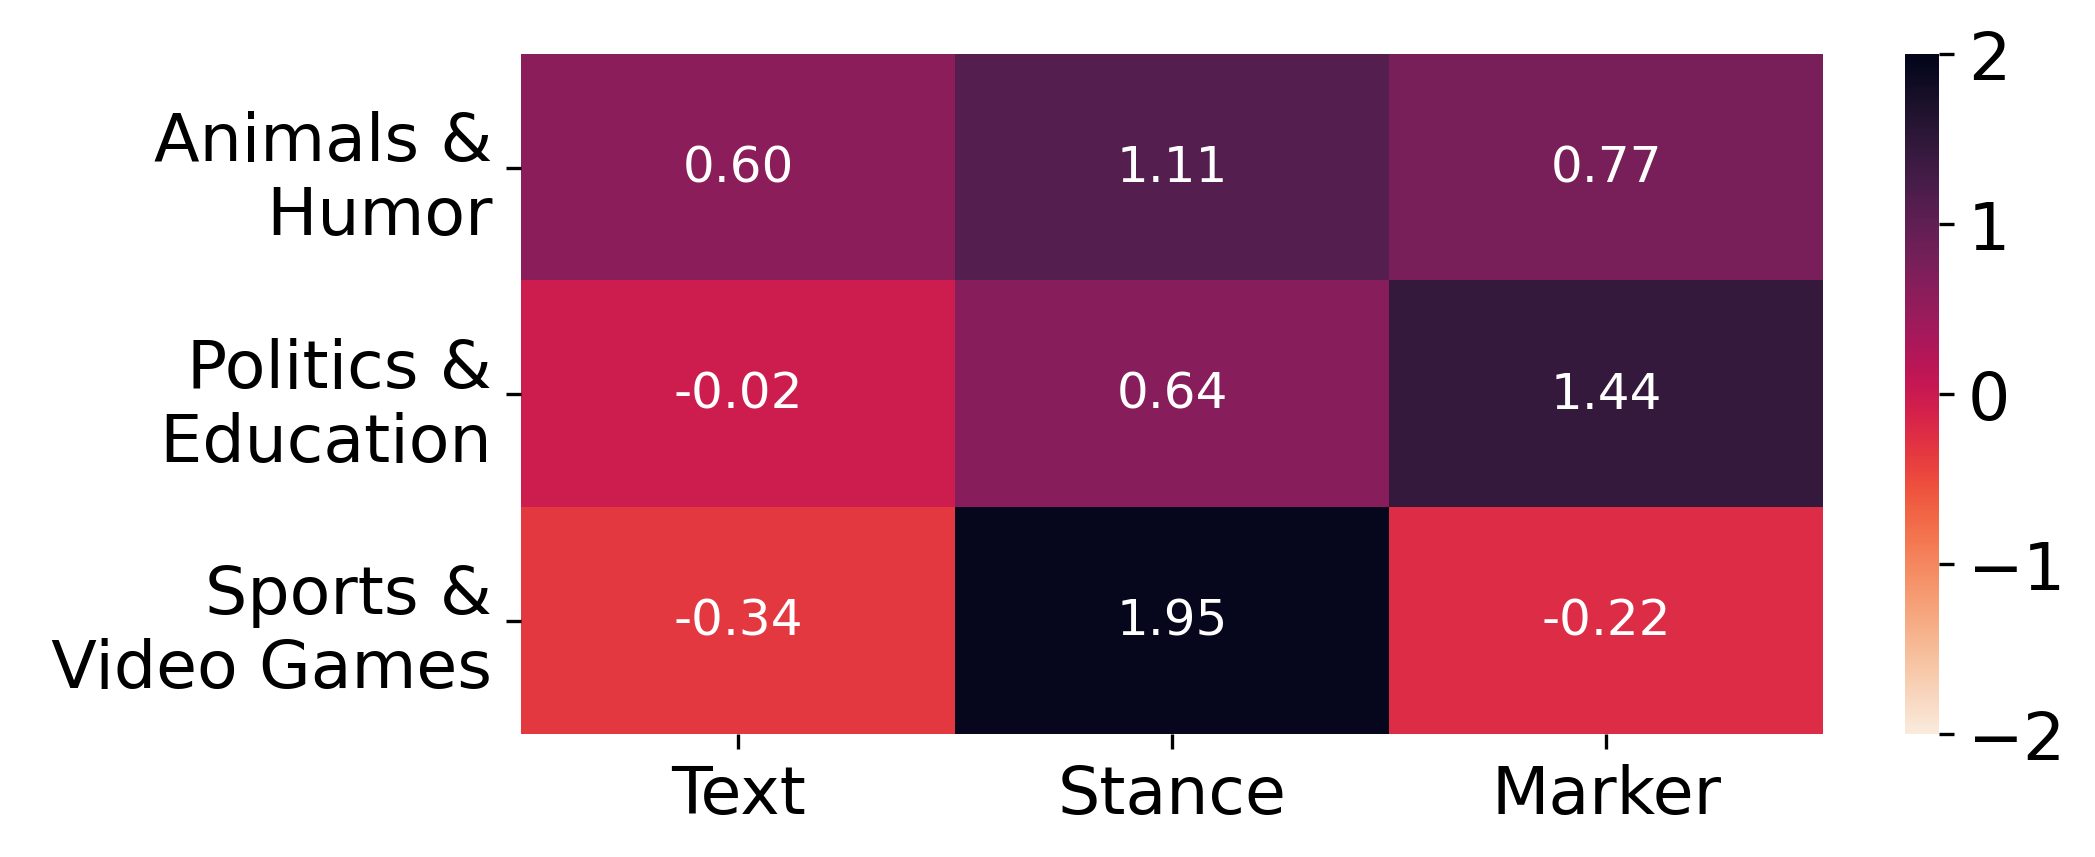

In [29]:
plt.rcParams['figure.dpi'] = 300
fig, ax = plt.subplots(figsize = (7,3))

font = {'font.size'   : 12,
        'xtick.labelsize': 16, #13 before
        'ytick.labelsize': 16,
        "axes.titlepad": 16}

plt.rcParams.update(font)
sb.heatmap(detailed_df.T, vmin=-2, vmax=2, cmap="rocket_r", annot=detailed_df.T, fmt=".2f", square=False, ax=ax)
plt.xticks(rotation=0) 
# plt.tight_layout()

# Crossposting

In [70]:
crossposting_df = pd.read_csv("../data_files/crossposting_full_community_data_2019.csv")
crossposting_df['com_1'] = crossposting_df['com_1'].str.lower()
crossposting_df['com_2'] = crossposting_df['com_2'].str.lower()

In [71]:
crossposting_df

,Unnamed: 0,com_1,com_2,pmi,id,status,label
0,4180,animemes,fantasyfootball,-1.038148,fantasyfootball___Animemes,LOW,0
1,4192,pewdiepiesubmissions,fantasyfootball,-0.756378,fantasyfootball___PewdiepieSubmissions,LOW,0
2,2209,warframe,fantasyfootball,-0.685117,Warframe___fantasyfootball,LOW,0
3,2071,personalfinance,animemes,-0.636201,personalfinance___Animemes,LOW,0
4,2083,pewdiepiesubmissions,personalfinance,-0.621605,personalfinance___PewdiepieSubmissions,LOW,0
...,...,...,...,...,...,...,...
777,3613,fifa,soccer,3.322370,FIFA___soccer,HIGH,1
778,1251,anime,grandorder,3.431919,grandorder___anime,HIGH,1
779,1008,collegebasketball,cfb,3.445987,CollegeBasketball___CFB,HIGH,1
780,934,reddevils,soccer,3.515170,reddevils___soccer,HIGH,1


In [72]:
# Pavalanathan baseline
full_vals = []
separated_vals = []
for i, row in crossposting_df.iterrows():
    com_1, com_2 = row['com_1'], row['com_2']
    
    ci1, ci2 = communities.index(com_1), communities.index(com_2)
    ci1_rep = pav_latent_representation[ci1].reshape(1, -1)
    ci2_rep = pav_latent_representation[ci2].reshape(1, -1)
    pav_full = cosine_similarity(ci1_rep, ci2_rep)[0][0]
    full_vals.append(pav_full)

    
    
    pav_separated = np.abs(ci1_rep - ci2_rep)[0]
    separated_vals.append(pav_separated)

crossposting_data = {
    "pav_ppmi_95_var": {
        "full": full_vals,
        "partial": separated_vals
    }
}

In [73]:
# This is for the community baseline
full_vals = []
separated_vals = []
for i, row in crossposting_df.iterrows():
    com_1, com_2 = row['com_1'], row['com_2']
    
    ci1_rep = rescaled_community_representation.loc[com_1].to_numpy().reshape(1, -1)
    ci2_rep = rescaled_community_representation.loc[com_2].to_numpy().reshape(1, -1)
    com_base_full = cosine_similarity(ci1_rep, ci2_rep)[0][0]
    full_vals.append(com_base_full)

    
    com_base_separated = np.abs(ci1_rep - ci2_rep)[0]
    separated_vals.append(com_base_separated)


crossposting_data['community_baseline'] =  {
        "full": full_vals,
        "partial": separated_vals
    }

In [75]:
crossposting_data['pav_ppmi_95_var']['full']

[0.1460539718579128,
 0.20200745932265812,
 0.7452874723831685,
 0.19374228636937407,
 0.24442587391420506,
 0.5098818859958542,
 0.15186138283802691,
 0.31152379602696356,
 0.432737433531357,
 0.3548795294763014,
 0.4151517612975765,
 0.31987269126509565,
 -0.017391965498335347,
 0.34397614005138305,
 0.3000431703411257,
 0.21944321288666113,
 0.27464403188384495,
 0.38167722575731533,
 0.04798235073084857,
 0.5511460038981993,
 0.4264939736668535,
 0.507279809398939,
 0.3577364368188404,
 0.5344146132586223,
 0.05962989629785719,
 0.13817540729483785,
 0.28200285622208277,
 0.14195756907543533,
 0.31217440468549457,
 0.404999190836394,
 0.08982706409375923,
 0.2659967374718189,
 0.07755376631725414,
 0.3306159867808467,
 0.406211906476903,
 0.3578287859778797,
 0.20513090401406575,
 0.17902805283809425,
 0.11292820508638526,
 0.3358304179548354,
 0.18366554608274732,
 0.5744776277544007,
 0.41856920050201374,
 0.17208940694669878,
 0.32055541750558814,
 0.3391082276962043,
 0.4102959

In [84]:
Serialization.save_obj(crossposting_data, "crossposting_regression_emnlp_validation_2024")

# Social Network Analyses

In [65]:
all(pav_df.index == contextual_df.index)

True

In [59]:
contextual_df = Serialization.load_obj(f"rq2_{data_suffix}_contextual_df_standardized")
pav_df = Serialization.load_obj(f"rq2_{data_suffix}_pav_df_11_dim")
# Align the dataframes
# contextual_df = contextual_df.loc[pav_df.index].T.loc[pav_df.columns].T

# # Convert similarities to differences
# contextual_diff_df = 1 - contextual_df
# pav_diff_df = 1 - pav_df

# # Compute distinctiveness
# contextual_distinctiveness = contextual_diff_df.sum()/(contextual_diff_df.shape[0] - 1)
# pav_distinctiveness = pav_diff_df.sum()/(pav_diff_df.shape[0] - 1)

# # Save objects
# Serialization.save_obj(contextual_distinctiveness, "2019_contextual_distinctiveness_scores_final")
# Serialization.save_obj(pav_distinctiveness, "2019_pav_distinctiveness_scores_final")

In [30]:
# Load other features
subreddit_agg_stats = Serialization.load_obj("2019_community_factors_num_unique_posts")
subreddit_author_stats = Serialization.load_obj("2019_community_factors_num_unique_authors")
loyal_users_per_subreddit = Serialization.load_obj("2019_loyal_users_per_subreddit")
users_per_subreddit = Serialization.load_obj("2019_top_level_commentors_per_subreddit")
density_per_subreddit = Serialization.load_obj("2019_community_factors_density") 

contextual_distinctiveness = Serialization.load_obj("2019_contextual_distinctiveness_scores_final")
pav_distinctiveness = Serialization.load_obj("2019_pav_distinctiveness_scores_final")

# Convert all indices to lower case
subreddit_agg_stats.index = subreddit_agg_stats.index.str.lower()
subreddit_author_stats.index = subreddit_author_stats.index.str.lower()
loyal_users_per_subreddit.index = loyal_users_per_subreddit.index.str.lower()
users_per_subreddit.index = users_per_subreddit.index.str.lower()
density_per_subreddit.index = density_per_subreddit.index.str.lower()

In [31]:
# Loyalty variable has 7.9K communities. We need to get the subset of these 
# communities that appear in our dataset.

core_communities_df = contextual_distinctiveness.reset_index()
core_communities_df.columns=['subreddit', 'dist']
loyal_users_per_subreddit = loyal_users_per_subreddit.reset_index()
lu_per_subreddit = core_communities_df.merge(loyal_users_per_subreddit, how='left', left_on="subreddit", right_on="subreddit")[['subreddit', 'author']].set_index("subreddit")

# Two communities have 0 loyal users, and so do not appear in the original loyalty
# variable. We fill these with 0.
lu_per_subreddit = lu_per_subreddit.fillna(0)

In [32]:
# Convert any DataFrames to Series
lu_per_subreddit = lu_per_subreddit['author']
users_per_subreddit = users_per_subreddit['author']
density_per_subreddit = density_per_subreddit[0]

In [33]:
# Reindex to all be the same
subreddit_agg_stats = subreddit_agg_stats.loc[contextual_distinctiveness.index]
subreddit_author_stats = subreddit_author_stats.loc[contextual_distinctiveness.index]
lu_per_subreddit = lu_per_subreddit.loc[contextual_distinctiveness.index]
users_per_subreddit = users_per_subreddit.loc[contextual_distinctiveness.index]
density_per_subreddit = density_per_subreddit.loc[contextual_distinctiveness.index]



In [34]:
# Compute normalized measures
loyalty_rate = lu_per_subreddit/users_per_subreddit
posting_rate = subreddit_agg_stats/subreddit_author_stats

In [35]:
dist_df = pd.concat((contextual_distinctiveness, 
                     pav_distinctiveness, 
                     posting_rate, 
                     subreddit_author_stats, 
                     loyalty_rate, 
                     density_per_subreddit), 
                     axis=1)

In [36]:
dist_df.columns = ['contextual_distinctiveness', 
                   'pav_distinctiveness',  
                   'activity', 
                   'size', 
                   'loyalty', 
                   'density']

In [37]:
dist_df = dist_df.sort_values(by='contextual_distinctiveness')

In [38]:
dist_df['log_size'] = np.log10(dist_df['size'])
dist_df['log_activity'] = np.log10(dist_df['activity'])
dist_df['log_loyalty'] = np.log10(dist_df['loyalty'] + min(dist_df['loyalty'][dist_df['loyalty'] != 0]))
dist_df['log_density'] = np.log10(dist_df['density'])

dist_df['norm_size'] = (dist_df['log_size'] - dist_df['log_size'].mean()) / dist_df['log_size'].std()
dist_df['norm_activity'] = (dist_df['log_activity'] - dist_df['log_activity'].mean()) / dist_df['log_activity'].std()
dist_df['norm_loyalty'] = (dist_df['log_loyalty'] - dist_df['log_loyalty'].mean()) / dist_df['log_loyalty'].std()
dist_df['norm_density'] = (dist_df['log_density'] - dist_df['log_density'].mean()) / dist_df['log_density'].std()
dist_df['norm_contextual_distinctiveness'] = (dist_df['contextual_distinctiveness'] - dist_df['contextual_distinctiveness'].mean()) / dist_df['contextual_distinctiveness'].std()
dist_df['norm_pav_distinctiveness'] = (dist_df['pav_distinctiveness'] - dist_df['pav_distinctiveness'].mean()) / dist_df['pav_distinctiveness'].std()

In [39]:
dist_df['topic'] = dist_df.index.map(all_topics['topic'].to_dict())

In [41]:
aggregate_topics_full_df = generate_similarity_df(dist_df)

In [44]:
aggregate_topics_full_df.groupby("topic").count().sort_values(by='activity')

,contextual_distinctiveness,pav_distinctiveness,activity,size,loyalty,density,log_size,log_activity,log_loyalty,log_density,norm_size,norm_activity,norm_loyalty,norm_density,norm_contextual_distinctiveness,norm_pav_distinctiveness
topic,,,,,,,,,,,,,,,,
animals,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7
nsfw,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15
general,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18
humor,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20
politics,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20
technology,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50
education,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70
discussion,84,84,84,84,84,84,84,84,84,84,84,84,84,84,84,84
hobbies,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94,94


In [45]:
print(spearmanr(dist_df['contextual_distinctiveness'], dist_df['size']))
print(spearmanr(dist_df['contextual_distinctiveness'], dist_df['activity']))
print(spearmanr(dist_df['contextual_distinctiveness'], dist_df['loyalty']))
print(spearmanr(dist_df['contextual_distinctiveness'], dist_df['density']))

SpearmanrResult(correlation=0.20860049081040652, pvalue=3.977281387653762e-19)
SpearmanrResult(correlation=-0.3616858229060554, pvalue=1.088547437678203e-56)
SpearmanrResult(correlation=-0.33789749622724785, pvalue=2.9017176223153203e-49)
SpearmanrResult(correlation=-0.3441339337938729, pvalue=3.781289650681084e-51)


In [68]:
loyal_users_per_subreddit.set_index("subreddit").loc[communities]

KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Index(['tech', 'youshouldknow'], dtype='object', name='subreddit'). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

In [47]:
print(spearmanr(dist_df['pav_distinctiveness'], dist_df['size']))
print(spearmanr(dist_df['pav_distinctiveness'], dist_df['activity']))
print(spearmanr(dist_df['pav_distinctiveness'], dist_df['loyalty']))
print(spearmanr(dist_df['pav_distinctiveness'], dist_df['density']))

SpearmanrResult(correlation=0.004951719467084282, pvalue=0.8338064563844794)
SpearmanrResult(correlation=-0.01844913511736988, pvalue=0.4343215179244444)
SpearmanrResult(correlation=0.1999526657336513, pvalue=1.1361590574466452e-17)
SpearmanrResult(correlation=0.014722990656977807, pvalue=0.5326958055657531)
